# 采样点展示

[Info] Loaded audio: ./samples/5Eh4NmbJ5-0.wav | Duration: 6.83s | Sample Rate: 16000Hz
[Info] Duration=6.83s | unit_dur=0.0533s | segment_sec=0.080s
min_gao_sec_ratio 0.3
extra_budget: [6 8 8 7 8 7 8 7 6 7 7 7 6 8 7 5] ==========len: 16 ========== Sum(extra_budget): 112
Final clip allocations (including anchors): [7 9 9 8 9 8 9 8 7 8 8 8 7 9 8 6] ========== len:  16 ========== Sum: 128
Total selected indices: 128
[0.134     0.1840625 0.2385    0.3475625 0.36575   0.3876875 0.4258125
 0.51625   0.5469375 0.5643125 0.5803125 0.6225625 0.6803125 0.7901875
 0.8209375 0.8428125 0.85825   0.8776875 0.89375   0.9099375 0.9268125
 0.961125  1.02575   1.04325   1.0645625 1.48375   1.4999375 1.5161875
 1.5321875 1.5514375 1.5841875 1.6563125 1.6724375 1.85      1.86625
 1.88525   1.913625  1.929625  1.954875  1.9830625 2.0036875 2.0196875
 2.31375   2.3299375 2.3585625 2.3746875 2.4506875 2.46675   2.5201875
 2.5485625 2.6980625 2.72675   2.7434375 2.77875   2.79475   2.8284375
 2.87775   2.894

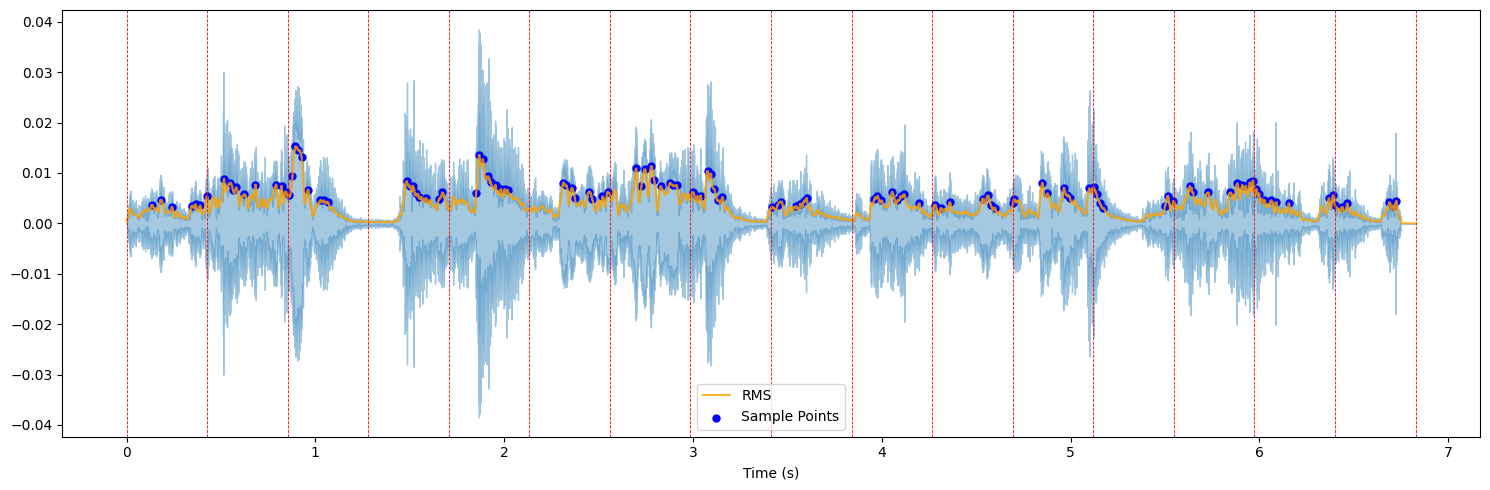

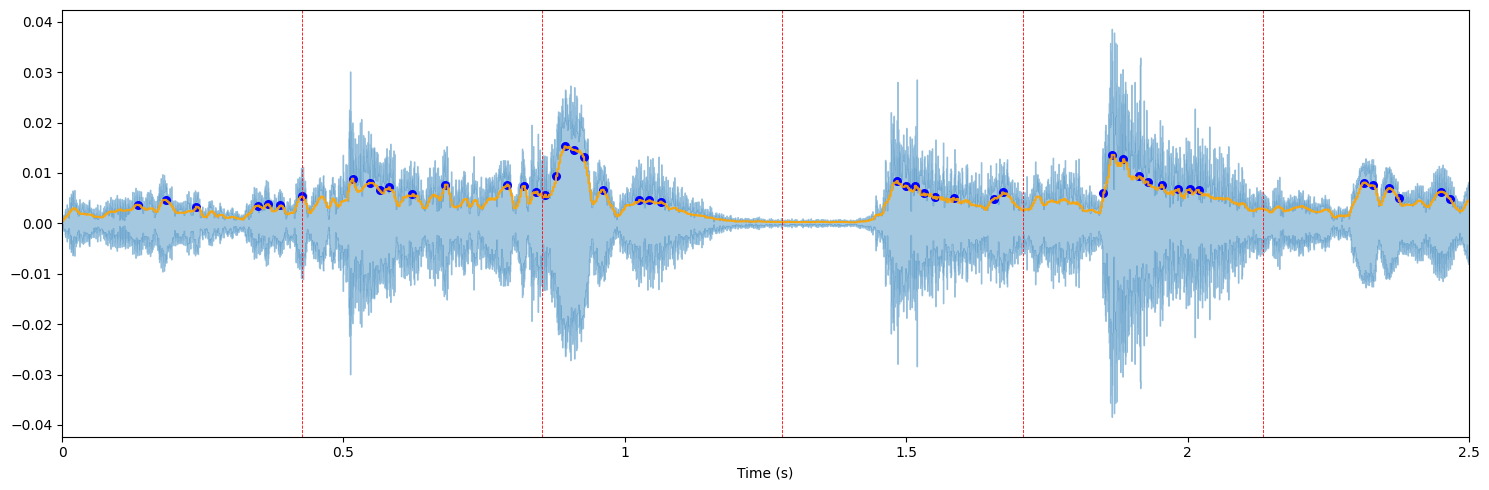

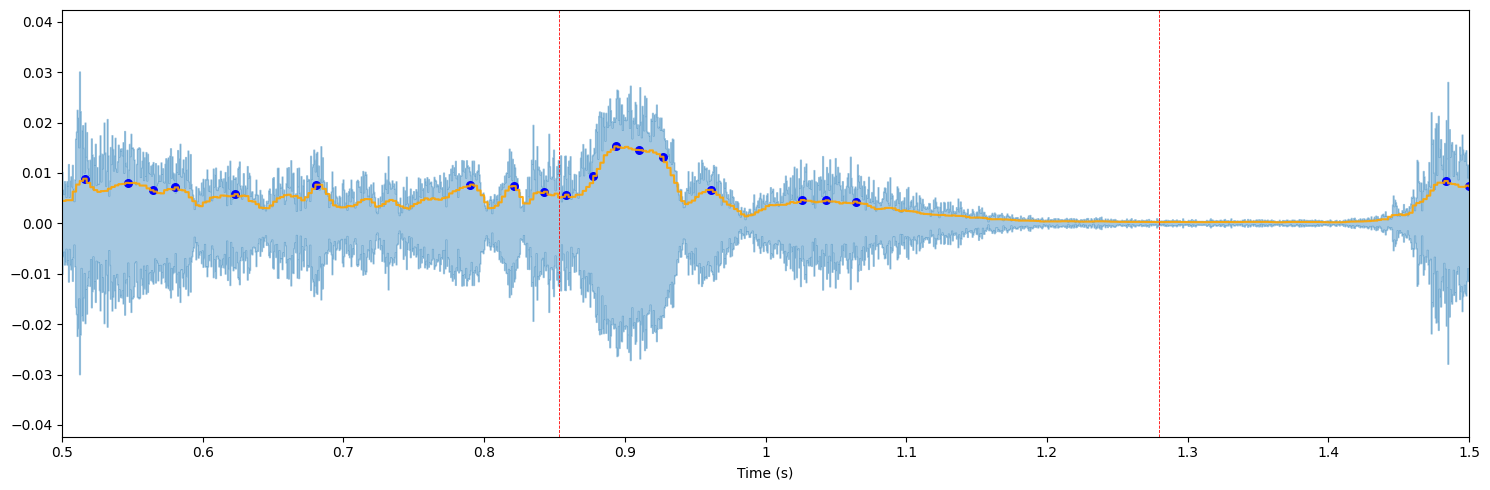

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt


def visualize_sampling(y, sr, rms_full, times, K=64, figsize=(10, 1)):
    """
    Global visualization of adaptive sampling.
    Red dashed lines indicate K clip boundaries.
    """

    audio_dur = len(y) / sr
    clip_sec = audio_dur / K

    plt.figure(figsize=figsize)

    # Waveform
    librosa.display.waveshow(y, sr=sr, alpha=0.4)

    # RMS curve
    t = np.arange(len(rms_full)) / sr
    plt.plot(t, rms_full, color='orange', alpha=0.8, label="RMS")

    # Clip boundaries (K)
    for i in range(K + 1):
        x = i * clip_sec
        plt.axvline(x=x, color='red', linestyle='--', linewidth=0.6)

    # Sampling points
    plt.scatter(
        times,
        np.interp(times, t, rms_full),
        color='blue',
        s=25,
        label="Sample Points"
    )

    # plt.title("Energy-Aware Adaptive RMS Sampling (Global)")
    plt.xlabel("Time (s)")
    plt.legend()
    plt.tight_layout()
    plt.show()


def visualize_sampling_zoom(y, sr, rms_full, times, K, start_sec, end_sec, figsize=(10, 1)):
    """
    Zoomed visualization of adaptive sampling.
    Red dashed lines indicate K clip boundaries.
    """

    audio_dur = len(y) / sr
    clip_sec = audio_dur / K

    plt.figure(figsize=figsize)
    t = np.arange(len(rms_full)) / sr

    # Waveform + RMS
    librosa.display.waveshow(y, sr=sr, alpha=0.4)
    plt.plot(t, rms_full, color='orange', alpha=0.9)

    # Sampling points in range
    mask = (times >= start_sec) & (times <= end_sec)
    plt.scatter(
        times[mask],
        np.interp(times[mask], t, rms_full),
        color='blue',
        s=30
    )

    # Clip boundaries (only those in view)
    for i in range(K + 1):
        x = i * clip_sec
        if start_sec <= x <= end_sec:
            plt.axvline(x=x, color='red', linestyle='--', linewidth=0.6)

    plt.xlim(start_sec, end_sec)
    # plt.title("Energy-Aware Adaptive RMS Sampling (Zoomed)")
    plt.xlabel("Time (s)")
    plt.tight_layout()
    plt.show()



# =====================================================
# 🔥🔥🔥adaptive_rms_sampling🔥🔥🔥
# =====================================================
def adaptive_rms_sampling(audio_path, y, sr, target_steps=128, K=64, frame_ms=10, hop_ratio=4, log_eps=1e-6, min_gao_sec_ratio=0.5, print_debug=False):
    """
    Energy-aware adaptive RMS sampling.

    Args:
        y (np.ndarray): audio waveform, shape (T,)
        sr (int): sample rate
        target_steps (int): total number of sampling points
        K (int): number of coarse clips
        frame_ms (float): RMS frame length in milliseconds
        hop_ratio (int): frame_len // hop_ratio
        log_eps (float): epsilon for log energy

    Returns:
        indices (List[int]): sampled indices (sample-level)
        times (np.ndarray): sampled times in seconds
        rms_full (np.ndarray): sample-level RMS curve
    """

    assert K <= target_steps, "K must be <= target_steps"


    dur = len(y) / sr

    ideal_gap_sec = dur / target_steps

    min_gap_sec = min_gao_sec_ratio * ideal_gap_sec
    min_gap_ms = max(8.0, min_gap_sec * 1000)

    clip_len_sec = dur / K
    max_extra_per_clip = max(
        1,
        int(clip_len_sec / min_gap_sec) - 1  
    )


    # =====================================================
    # 1. RMS computation (frame-level -> sample-level)
    # =====================================================


    frame_len = int(sr * frame_ms / 1000)
    hop_len = max(1, frame_len // hop_ratio)


    # Frame-level RMS
    rms = librosa.feature.rms(
        y=y,
        frame_length=frame_len,
        hop_length=hop_len
    )[0]


    per_clip_RMS = len(rms) / K

    rms_full = np.repeat(rms, hop_len) 

    rms_full = rms_full[:len(y)]


    audio_len = len(y)


    # =====================================================
    # 2. Split into K clips
    # =====================================================
    clip_len = audio_len // K
    clip_ranges = []  

    for i in range(K):
        s = i * clip_len
        e = audio_len if i == K - 1 else (i + 1) * clip_len
        clip_ranges.append((s, e))



    # =====================================================
    # 3. Stage-1: one anchor per clip (plateau-center argmax) 
    # =====================================================
    anchors = [] 

    for (s, e) in clip_ranges:
        seg = rms_full[s:e]
        if len(seg) == 0:
            anchors.append(s)
            continue

        max_val = seg.max() 
        idxs = np.flatnonzero(seg == max_val) 
        local_idx = idxs[len(idxs) // 2]   
        anchors.append(s + local_idx) 

    # =====================================================
    # 4. Clip energy & log-weights  
    # =====================================================
    energies = np.array([
        np.sum(rms_full[s:e]) for (s, e) in clip_ranges 
    ])


    weights = np.log(energies + log_eps)  
    weights = np.maximum(weights, 0.0)  



    # =====================================================
    # 5. Allocate remaining budget (STRICT sum = remain)
    # =====================================================
    remain = target_steps - K  

    if remain <= 0: 
        indices = sorted(anchors)[:target_steps]  
        times = np.array(indices) / sr 
        if print_debug:
            print("min_gao_sec_ratio", min_gao_sec_ratio)
            print("anchors", len(anchors), '\n\n')
        return indices, times, rms_full 

    if weights.sum() > 0: 
        weights_normalized = weights / weights.sum()  
        alloc_float = weights_normalized * remain  

    else:  
        alloc_float = np.zeros_like(weights)  


    # ---- integer allocation with largest remainder ---- 
    alloc_floor = np.floor(alloc_float).astype(int)  

    remainder = alloc_float - alloc_floor 

    missing = remain - alloc_floor.sum() 
    assert missing >= 0  

    # distribute the remaining budget
    if missing > 0:
        order = np.argsort(remainder)[::-1]  
        for i in order[:missing]: 
            alloc_floor[i] += 1

    extra_budget = alloc_floor 

    
    clip_allocations = extra_budget + 1  
    # print("\nFinal clip allocations (including anchors):", clip_allocations, 'len: ', len(clip_allocations), "\nSum:", clip_allocations.sum())




    # =====================================================
    # 6. Stage-2: collect extra candidates (DO NOT merge yet)  
    # =====================================================
    min_gap = int(sr * min_gap_ms / 1000)  
    extra_candidates = []  

    for i, ((s, e), b) in enumerate(zip(clip_ranges, extra_budget)):  
        if b <= 0:
            continue

        b = min(b, max_extra_per_clip)  
        seg = rms_full[s:e]
        if len(seg) == 0:  
            continue

        order = np.argsort(seg)[::-1]  
        selected = []

        for idx in order:  
            pos = s + idx

            # suppress near anchors  
            if abs(pos - anchors[i]) < min_gap:
                continue

            # suppress near selected
            if any(abs(pos - p) < min_gap for p in selected):
                continue

            selected.append(pos)
            extra_candidates.append((pos, seg[idx]))  

            if len(selected) >= b:
                break


    # =====================================================
    # 7. Final merge (anchors are NEVER removed)
    # =====================================================
    remain = target_steps - len(anchors)  

    extra_candidates.sort(key=lambda x: x[1], reverse=True)  
    extra_selected = [p for p, _ in extra_candidates[:max(0, remain)]]  

    indices = sorted(anchors + extra_selected)


    if print_debug:
        print("min_gao_sec_ratio", min_gao_sec_ratio)
        print("extra_budget:", extra_budget, "==========len:", len(extra_budget), "========== Sum(extra_budget):", extra_budget.sum())
        print("Final clip allocations (including anchors):", clip_allocations, '========== len: ', len(clip_allocations), "========== Sum:", clip_allocations.sum())
        print("Total selected indices:", len(indices))
        print(np.array(indices) / sr, '\n\n')


    # =====================================================
    # 8. Fallback uniform sampling (guarantee target_steps)
    # =====================================================
    cur_num = len(indices)

    if cur_num < target_steps:
        missing = target_steps - cur_num
        print(f"{audio_path}   : Warning - only ** {cur_num} ** points selected, need ** {missing} ** more. Fallback to uniform sampling.")

        # 在 [0, audio_len)
        uniform_positions = np.linspace(
            0, audio_len - 1, num=missing + 2, dtype=int
        )

        existing = set(indices)
        uniform_selected = []

        for p in uniform_positions:
            if p not in existing:
                uniform_selected.append(p)
                existing.add(p)
            if len(uniform_selected) >= missing:
                break

        indices = sorted(indices + uniform_selected)

    if len(indices) > target_steps:
        indices = indices[:target_steps]



    times = np.array(indices) / sr

    if print_debug:
        print("min_gao_sec_ratio", min_gao_sec_ratio)
        print("extra_budget:", extra_budget, "==========len:", len(extra_budget), "========== Sum(extra_budget):", extra_budget.sum())
        print("Final clip allocations (including anchors):", clip_allocations, '========== len: ', len(clip_allocations), "========== Sum:", clip_allocations.sum())
        print("Total selected indices:", len(indices), len(times))
        print(times, '\n\n')



    return indices, times, rms_full




# =====================================================
# 5) Pipeline
# =====================================================
def extract_audio_embedding(audio_path, target_steps=128, sr_target=16000, frame_ms=10, hop_ratio=4, k=16, min_gao_sec_ratio=0.25, print_debug=False, figsize=(10, 3)):
    
    # ① Load audio
    y, sr = librosa.load(audio_path, sr=sr_target)

    dur = len(y) / sr
    print(f"[Info] Loaded audio: {audio_path} | Duration: {dur:.2f}s | Sample Rate: {sr}Hz")
    
    unit_dur = dur / target_steps
    segment_sec = max(unit_dur, 0.08)

    print(
        f"[Info] Duration={dur:.2f}s | "
        f"unit_dur={unit_dur:.4f}s | "
        f"segment_sec={segment_sec:.3f}s"
    )

    indices, times, rms_full = adaptive_rms_sampling(
        audio_path,
        y,
        sr,
        target_steps=target_steps,
        K=k,
        frame_ms=frame_ms,
        hop_ratio=hop_ratio,
        log_eps=1e-6,
        min_gao_sec_ratio=min_gao_sec_ratio,
        print_debug=print_debug
    )

    if 1:
        visualize_sampling(y, sr, rms_full, times, k, figsize=figsize)
        visualize_sampling_zoom(y, sr, rms_full, times, k, 0.0, 2.5, figsize=figsize)
        visualize_sampling_zoom(y, sr, rms_full, times, k, 0.5, 1.5, figsize=figsize)

    return 1

# =====================================================
# 6) run
# =====================================================
if __name__ == "__main__":
    audio_path = "./samples/5Eh4NmbJ5-0.wav"
    feats = extract_audio_embedding(audio_path, target_steps=128, sr_target=16000, frame_ms=10, hop_ratio=4, k=16, min_gao_sec_ratio=0.3, print_debug=True, figsize=(15, 5))